# Outline

1. Prepare project
    * Import libraries, set up graph quality tweaks and progress bar
    * Open data files
2. EDA
    * Number of reviews over time
    * Number of reviews per movie
    * Distribution of ratings (on a scale of 1-10)
    * Distribution of polarities over time
3. Data preprocessing 
    * Compose evaluation routine for models
    * Normalize text
    * Split into train and test sets
4. Train and evaluate models
    * Dummy model to establish baseline
    * NLTK, TF-idf, and Logistic Regression
    * SpaCy, TF-idf, and Logistic Regression
    * SpaCy, TF-idf, and LGBMClassifier
    * BERT
5. Test models on reviews I wrote
6. Conclusion


### Objective
Train a model for Film Junky Union's system for filtering and categorizing movie reviews. This project uses a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Prepare project

In [1]:
import math
import re

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm

In [2]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [4]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
print(len(df_reviews[df_reviews['ds_part'] == 'train']))

23796


In [8]:
df_reviews = df_reviews.dropna()

## EDA

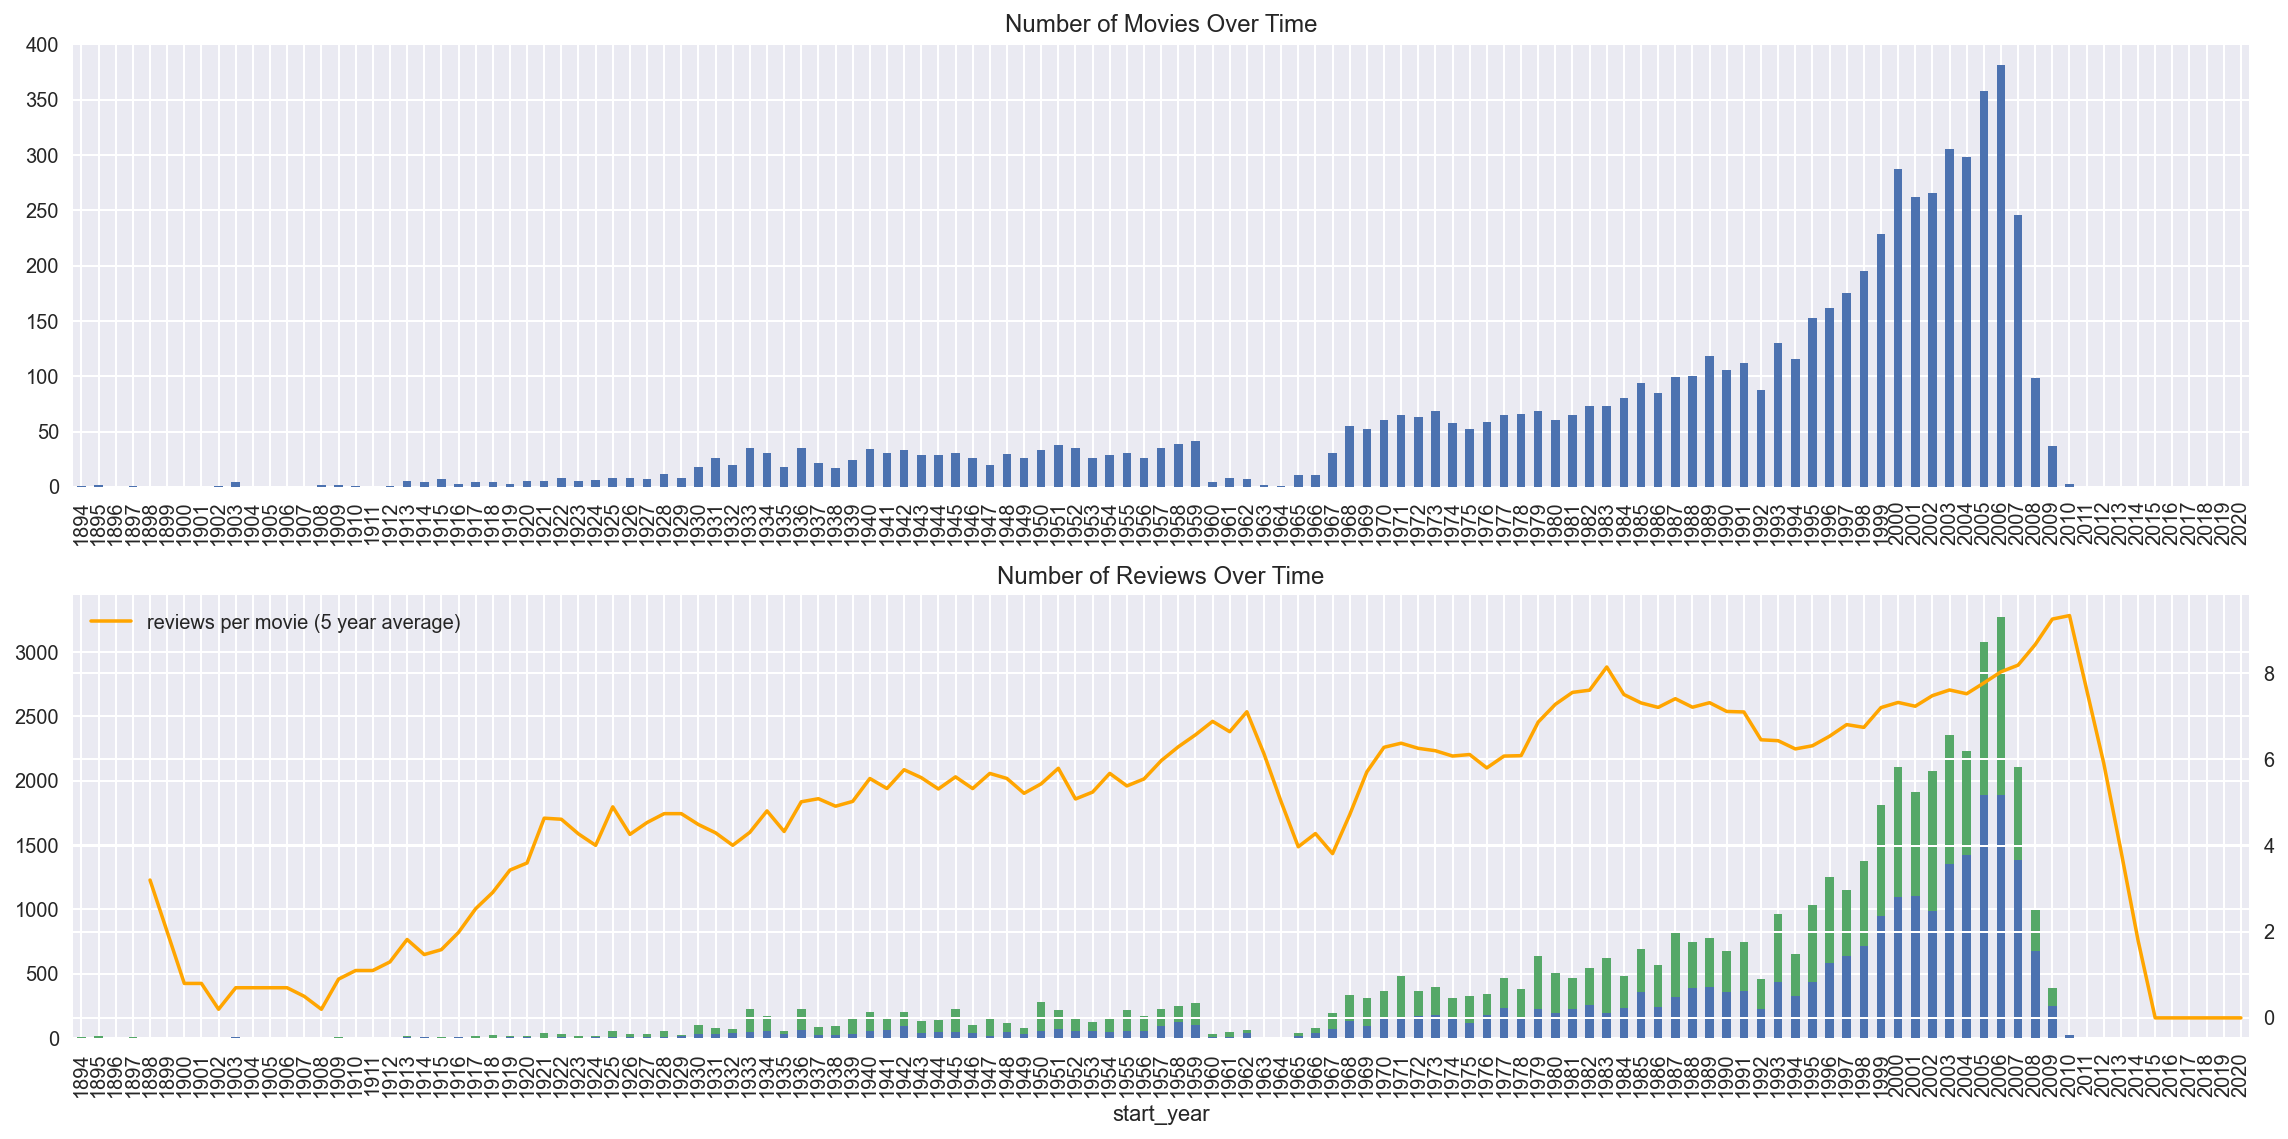

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Time')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (5 year average)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Time')

fig.tight_layout()

The data only goes to 2010 (and that is obviously not complete), but clearly more movies get released per year over time. Also interesting is that there is a steep drop after 2007, which could relate to the recession, or could simply be due to less data collected for more recent years. 

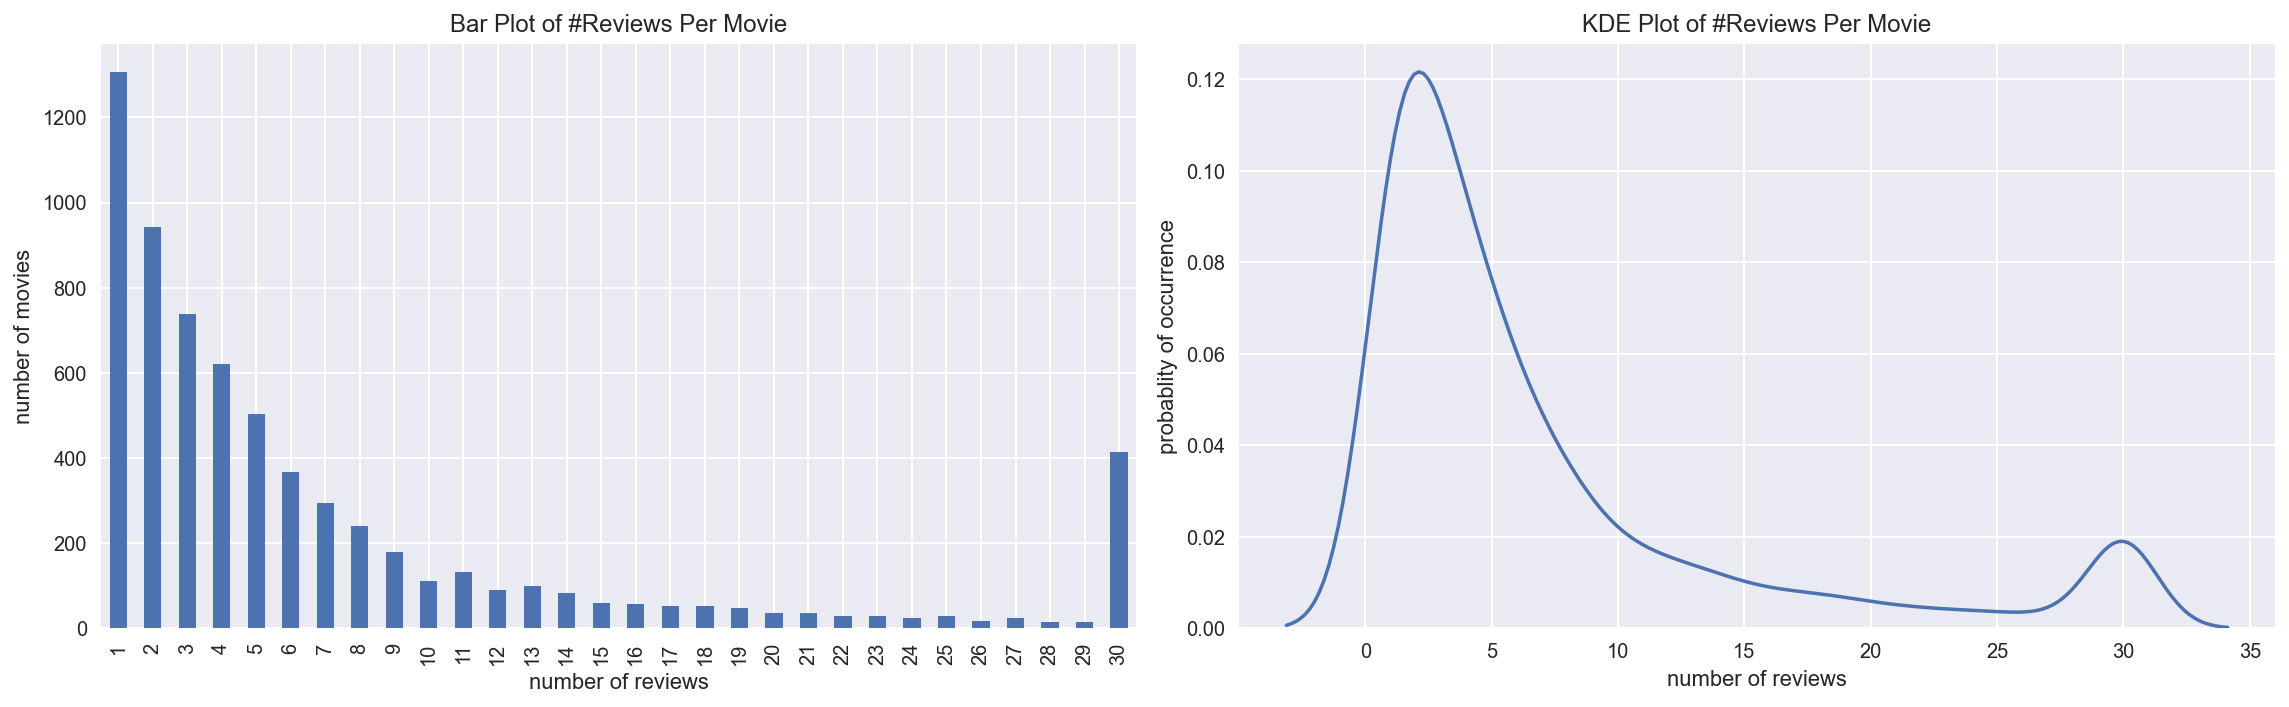

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count().value_counts().sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')
ax.set_xlabel('number of reviews')
ax.set_ylabel('number of movies')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')
ax.set_xlabel('number of reviews')
ax.set_ylabel('probablity of occurrence')

fig.tight_layout()

Most movies only have a couple reviews, but there is a spike at 30 reviews that could be investigated at some point.

In [11]:
df_reviews.query('ds_part == "train"')['pos'].value_counts()

0    11912
1    11884
Name: pos, dtype: int64

In [12]:
df_reviews.query('ds_part == "test"')['pos'].value_counts()

0    11803
1    11730
Name: pos, dtype: int64

Both the training and test data have fairly balanced classes. They differ in both sets by ~100 observations, or .85% and I feel that this is not enough to warrant balancing them further. 

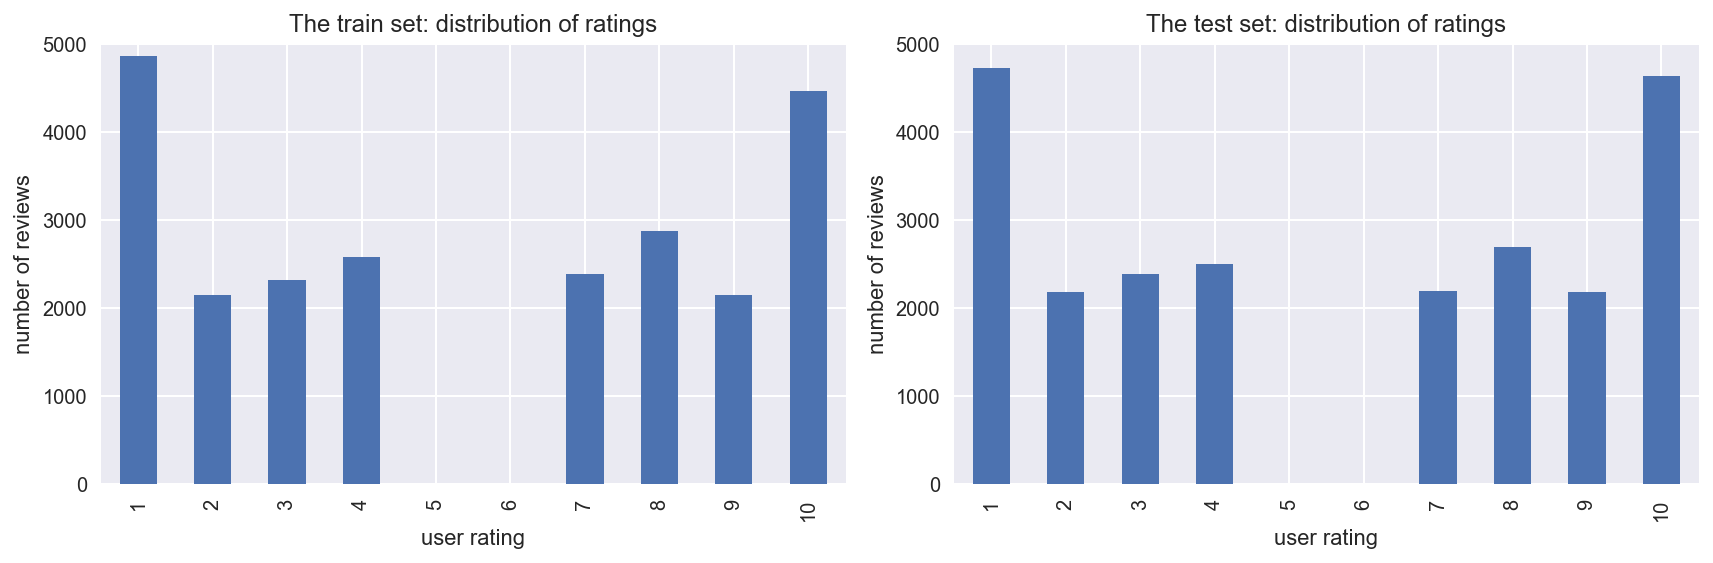

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')
ax.set_xlabel('user rating')
ax.set_ylabel('number of reviews')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')
ax.set_xlabel('user rating')
ax.set_ylabel('number of reviews')

fig.tight_layout()

The distribution of ratings for both training and test data show that people generally write a review when they absolutely love or hate a movie. Indifferent reviews are almost nonexistent.

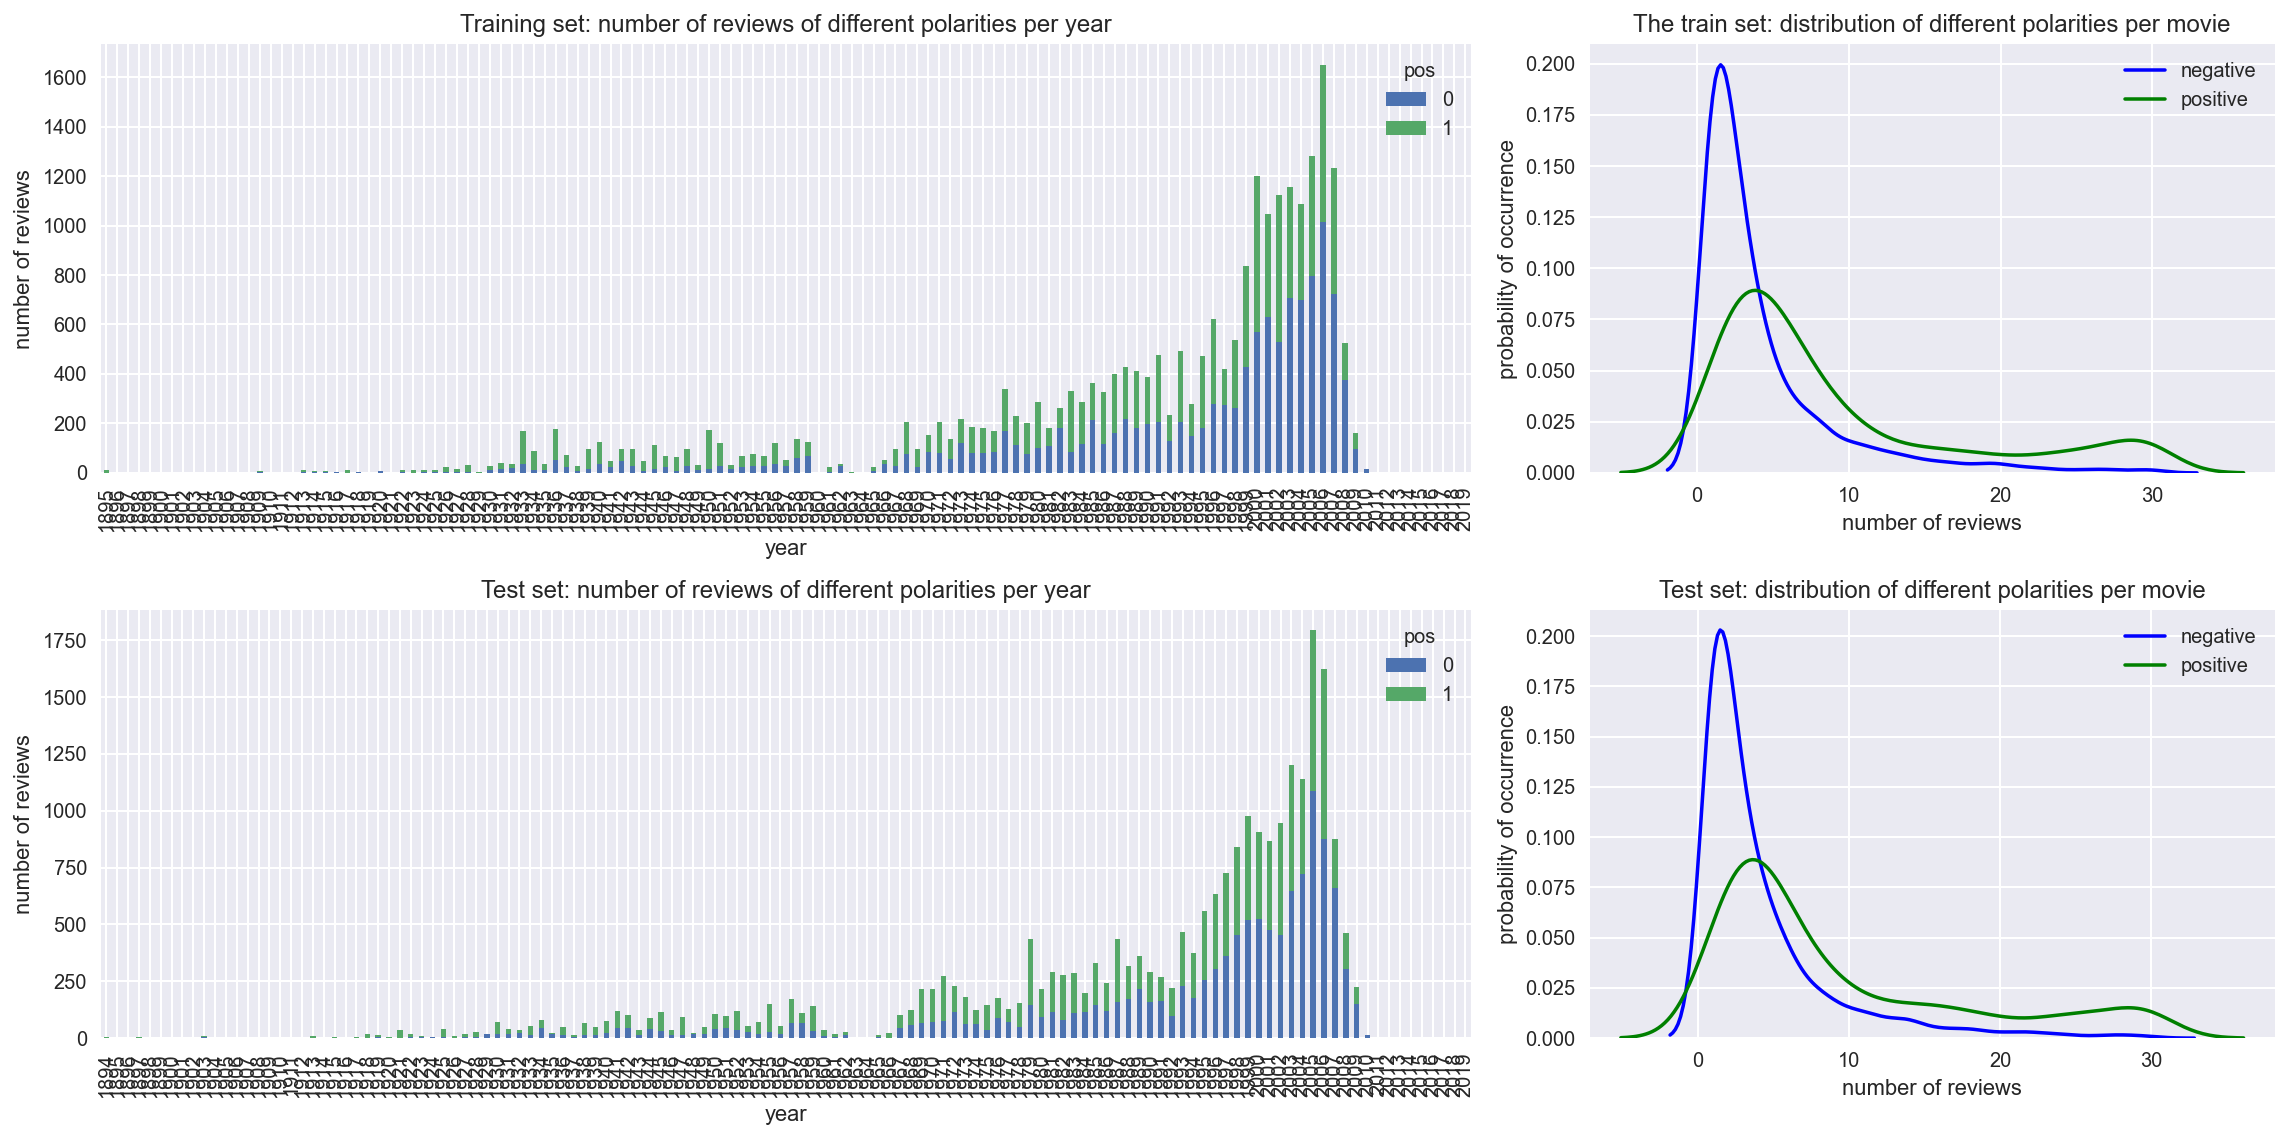

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Training set: number of reviews of different polarities per year')
ax.set_xlabel('year')
ax.set_ylabel('number of reviews')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')
ax.set_xlabel('number of reviews')
ax.set_ylabel('probability of occurrence')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: number of reviews of different polarities per year')
ax.set_xlabel('year')
ax.set_ylabel('number of reviews')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Test set: distribution of different polarities per movie')
ax.set_xlabel('number of reviews')
ax.set_ylabel('probability of occurrence')

fig.tight_layout()

The graphs on the left show that the number of positive and negative reviews per year are distributed similarly in the training and test sets. On the right, they indicate that the probablity of a given number of both negative and positive reviews are quite similar for both sets as well. 

## Data preprocessing

### Compose an evaluation routine that can be used for all models in this project

In [15]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

### Normalization

In [16]:
def normalize_text(text):
    text = re.sub(r'[^a-z]', ' ', text.lower())
    return ' '.join(text.split())

In [17]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

In [18]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i m totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

To prepare the reviews for models, I used a regular expression to filter out everything but letters, and converted the texts to all lowercase.

### Train/test split

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

## Train and evaluate models

### Model 1 - constant

In [20]:
from sklearn.dummy import DummyClassifier

In [21]:
dummy_clf = DummyClassifier(strategy='constant', constant=0)

In [22]:
dummy_clf.fit(df_reviews_train, train_target)

DummyClassifier(constant=0, strategy='constant')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


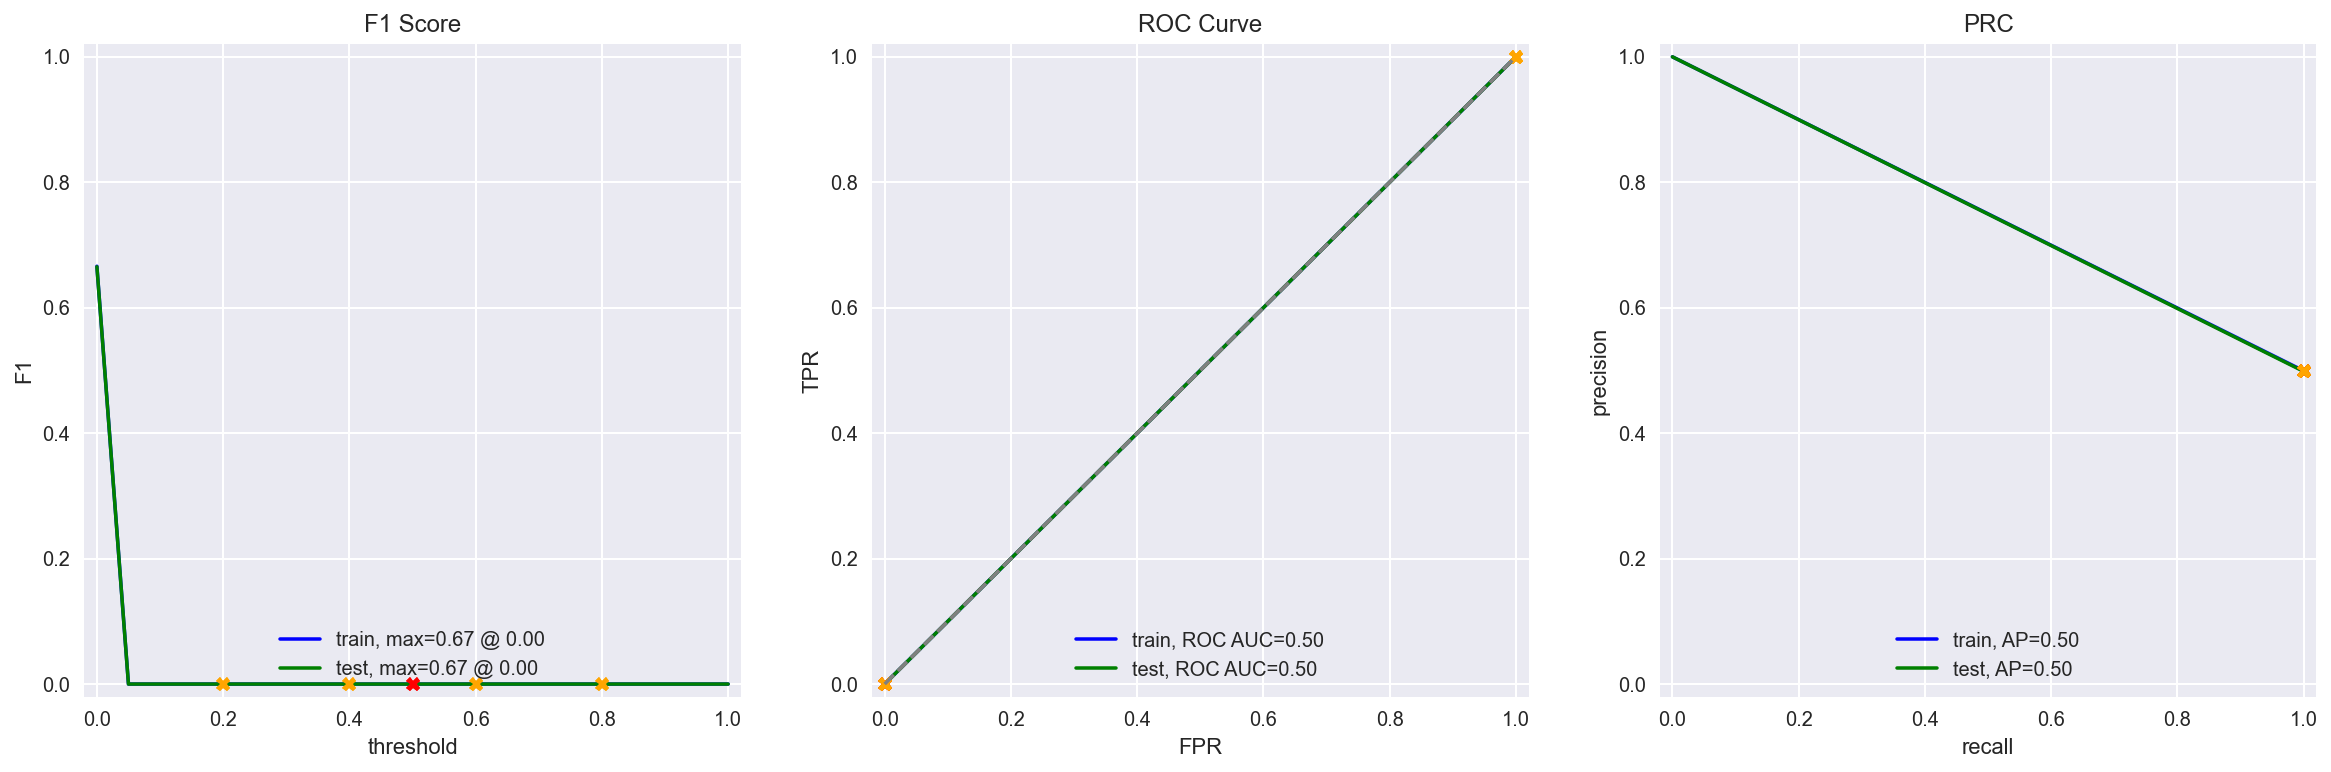

In [23]:
evaluate_model(dummy_clf, df_reviews_train, train_target, df_reviews_test, test_target)

This dummy classifier demonstrates using a constant for a "prediction" to establish a baseline for my trained models. Since the classes are fairly balanced, it is expected that the dummy model would get it right half the time. The F1 score cannot be calculated with the approach, but I can compare my other metrics to this baseline of .5. If my trained models are getting similar scores, something has gone awry. 

### Model 2 - NLTK, TF-IDF and LR

In [30]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords as nltk_stopwords

In [31]:
stop_words = set(nltk_stopwords.words('english'))

tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)

train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'])
test_features_2 = tfidf_vectorizer_2.transform(df_reviews_test['review_norm'])

In [32]:
model_2 = LogisticRegression()
model_2.fit(train_features_2, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


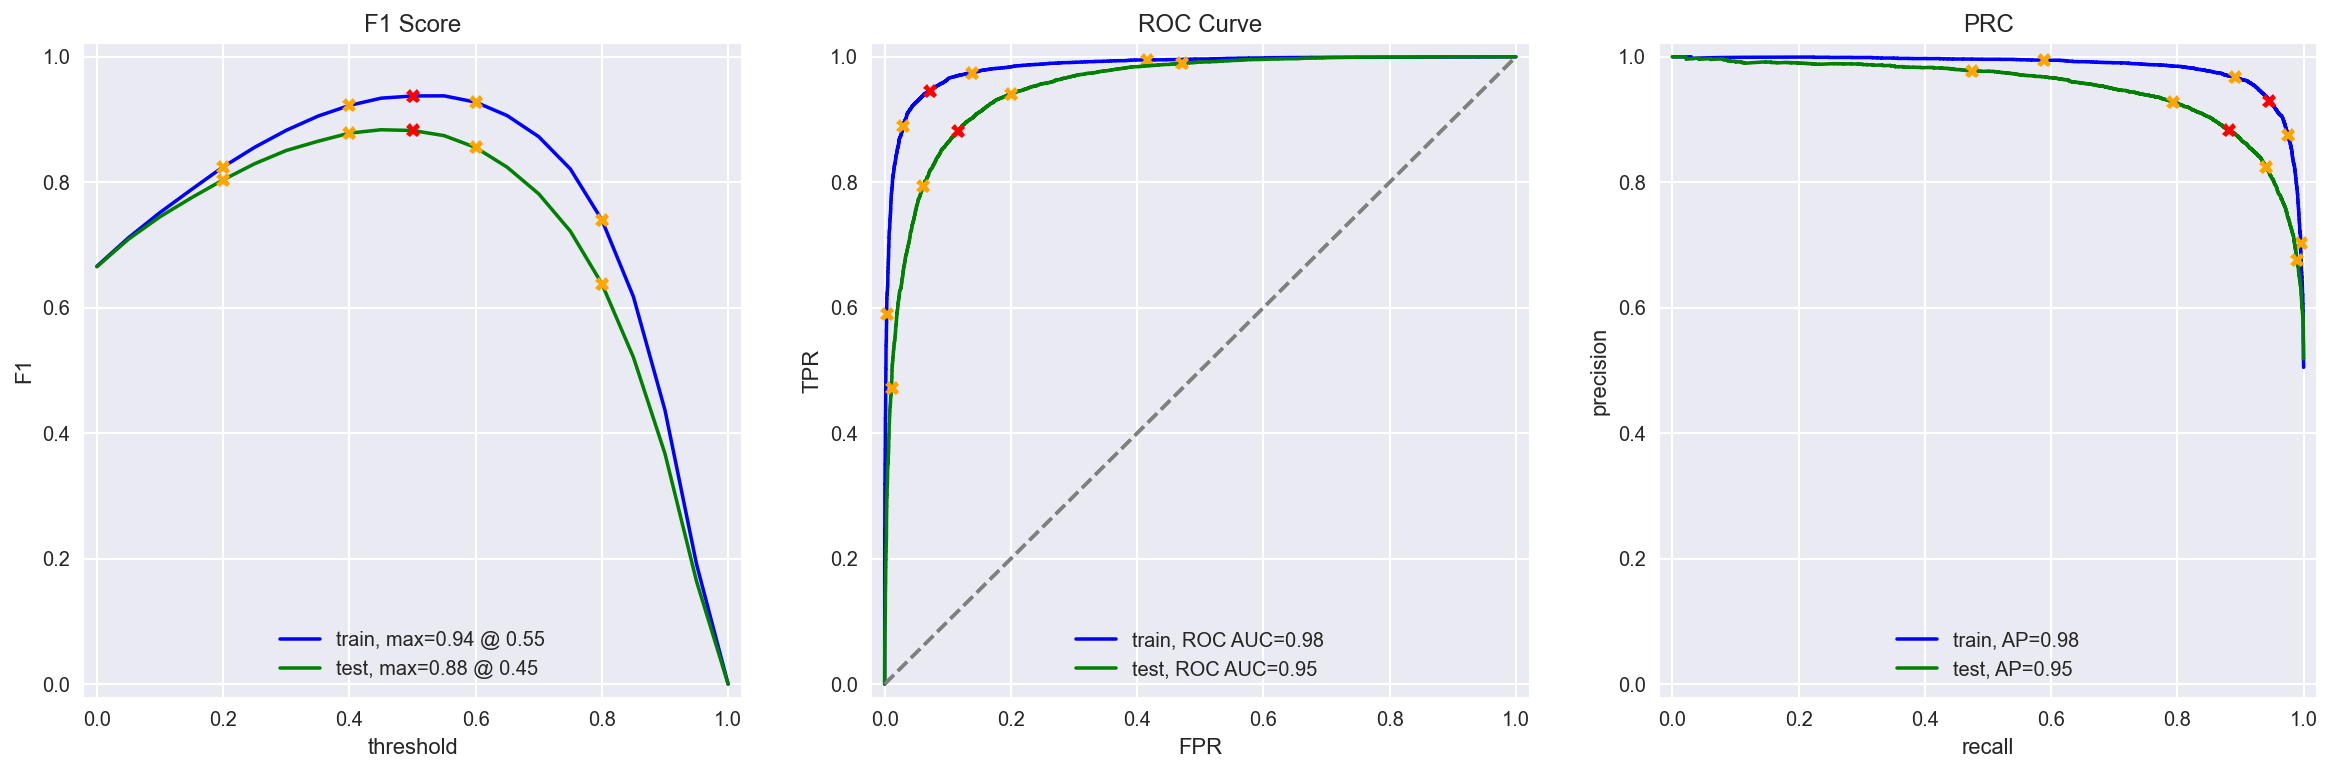

In [33]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en_core_web_sm

In [37]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [38]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [39]:
df_reviews_train['review_spcy_tokenized'] = df_reviews_train['review_norm'].apply(lambda x: text_preprocessing_3(x))

df_reviews_test['review_spcy_tokenized'] = df_reviews_test['review_norm'].apply(lambda x: text_preprocessing_3(x))

In [40]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)

In [41]:
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_spcy_tokenized'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_spcy_tokenized'])

In [42]:
model_3 = LogisticRegression()

model_3.fit(train_features_3, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


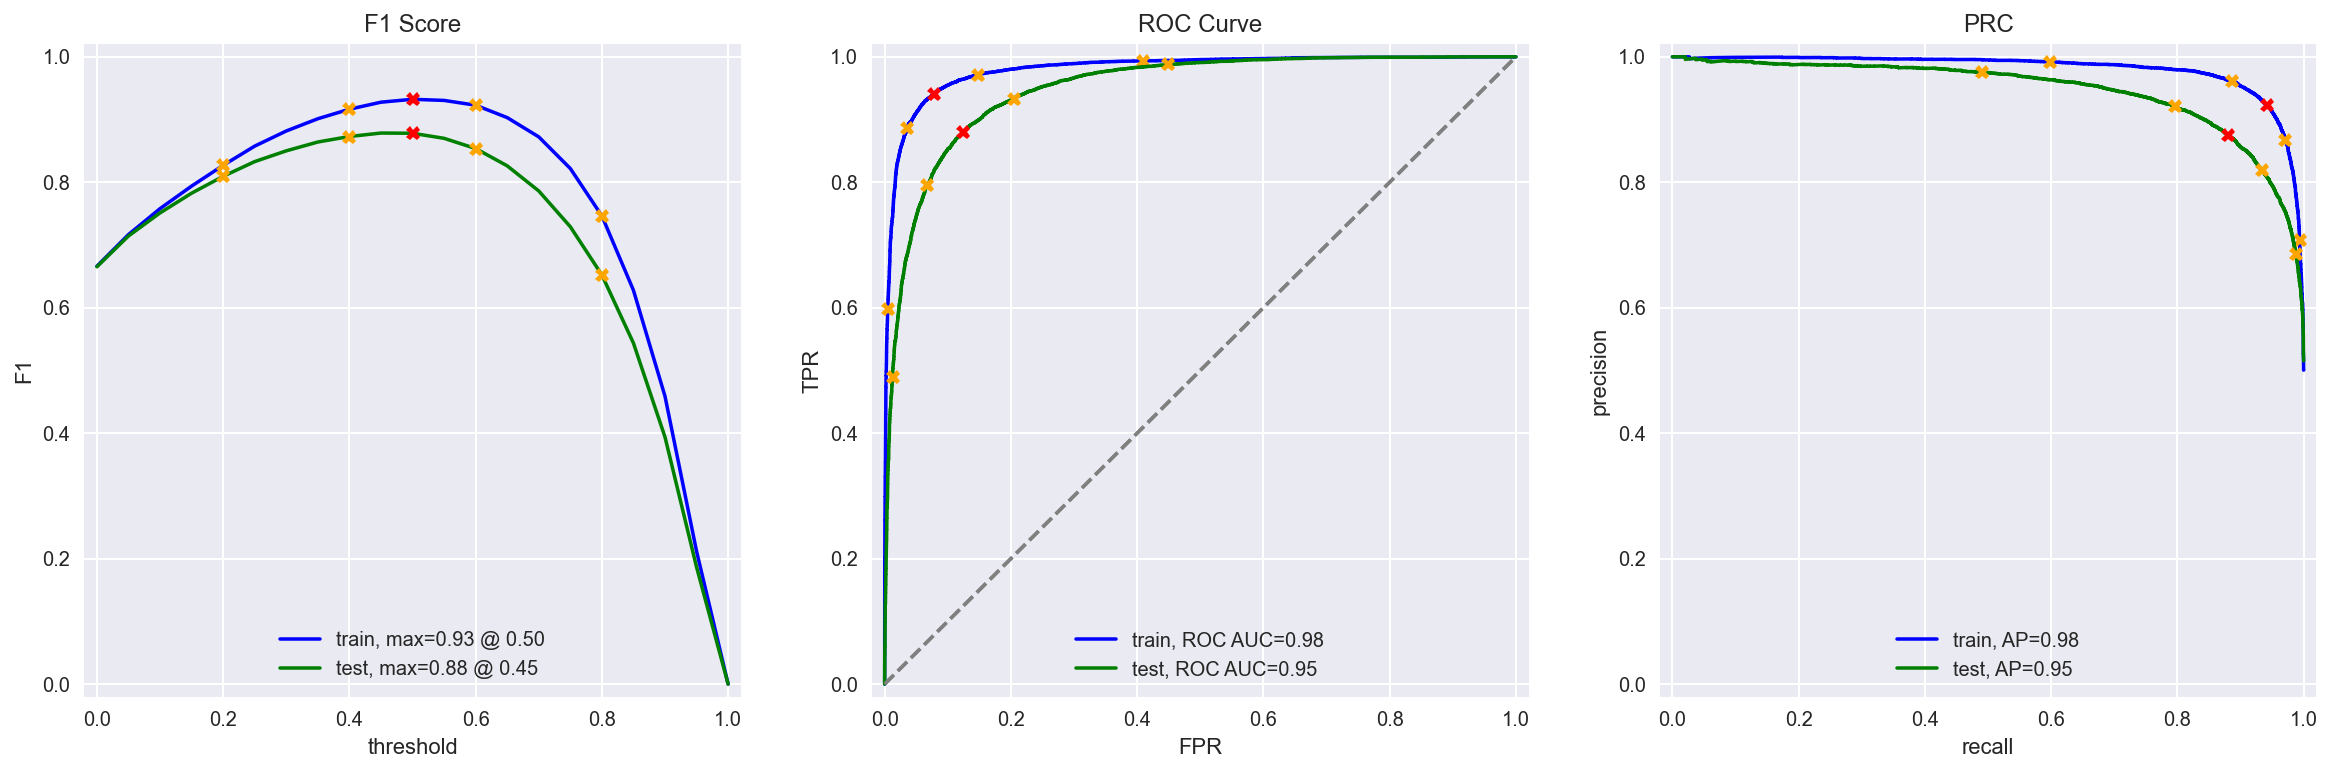

In [43]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

Both logistic regression models - one using spaCy to lemmatize and one that did not - got similar scores. The F1 score (the weighted average of precision and recall) drops a bit for the test portion of the data, so the models are a little overfitted, but it is stll above the target score threshold.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [45]:
!pip install lightgbm

In [46]:
from lightgbm import LGBMClassifier

In [47]:
model_4 = LGBMClassifier(learning_rate=.3, early_stopping_rounds=200, silent=True,
                        random_state=12345)

In [48]:
tfidf_vectorizer_4 = TfidfVectorizer(stop_words=stop_words)

train_features_4 = tfidf_vectorizer_4.fit_transform(df_reviews_train['review_spcy_tokenized'])
test_features_4 = tfidf_vectorizer_4.transform(df_reviews_test['review_spcy_tokenized'])

In [49]:
train_feat_LGBM, valid_feat_LGBM, train_target_LGBM, valid_target_LGBM = train_test_split(
    train_features_4, train_target, test_size=.25, random_state=12345)

In [50]:
model_4.fit(train_feat_LGBM, train_target_LGBM, eval_set=(valid_feat_LGBM, valid_target_LGBM),
           eval_metric='f1', verbose=10)

[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[10]	valid_0's binary_logloss: 0.438496
[20]	valid_0's binary_logloss: 0.378361
[30]	valid_0's binary_logloss: 0.354837
[40]	valid_0's binary_logloss: 0.340674
[50]	valid_0's binary_logloss: 0.33458
[60]	valid_0's binary_logloss: 0.328584
[70]	valid_0's binary_logloss: 0.324556
[80]	valid_0's binary_logloss: 0.323818
[90]	valid_0's binary_logloss: 0.32382
[100]	valid_0's binary_logloss: 0.322107


LGBMClassifier(early_stopping_rounds=200, learning_rate=0.3, random_state=12345,
               silent=True)

          train  test
Accuracy   0.96  0.86
F1         0.96  0.86
APS        0.99  0.93
ROC AUC    0.99  0.94


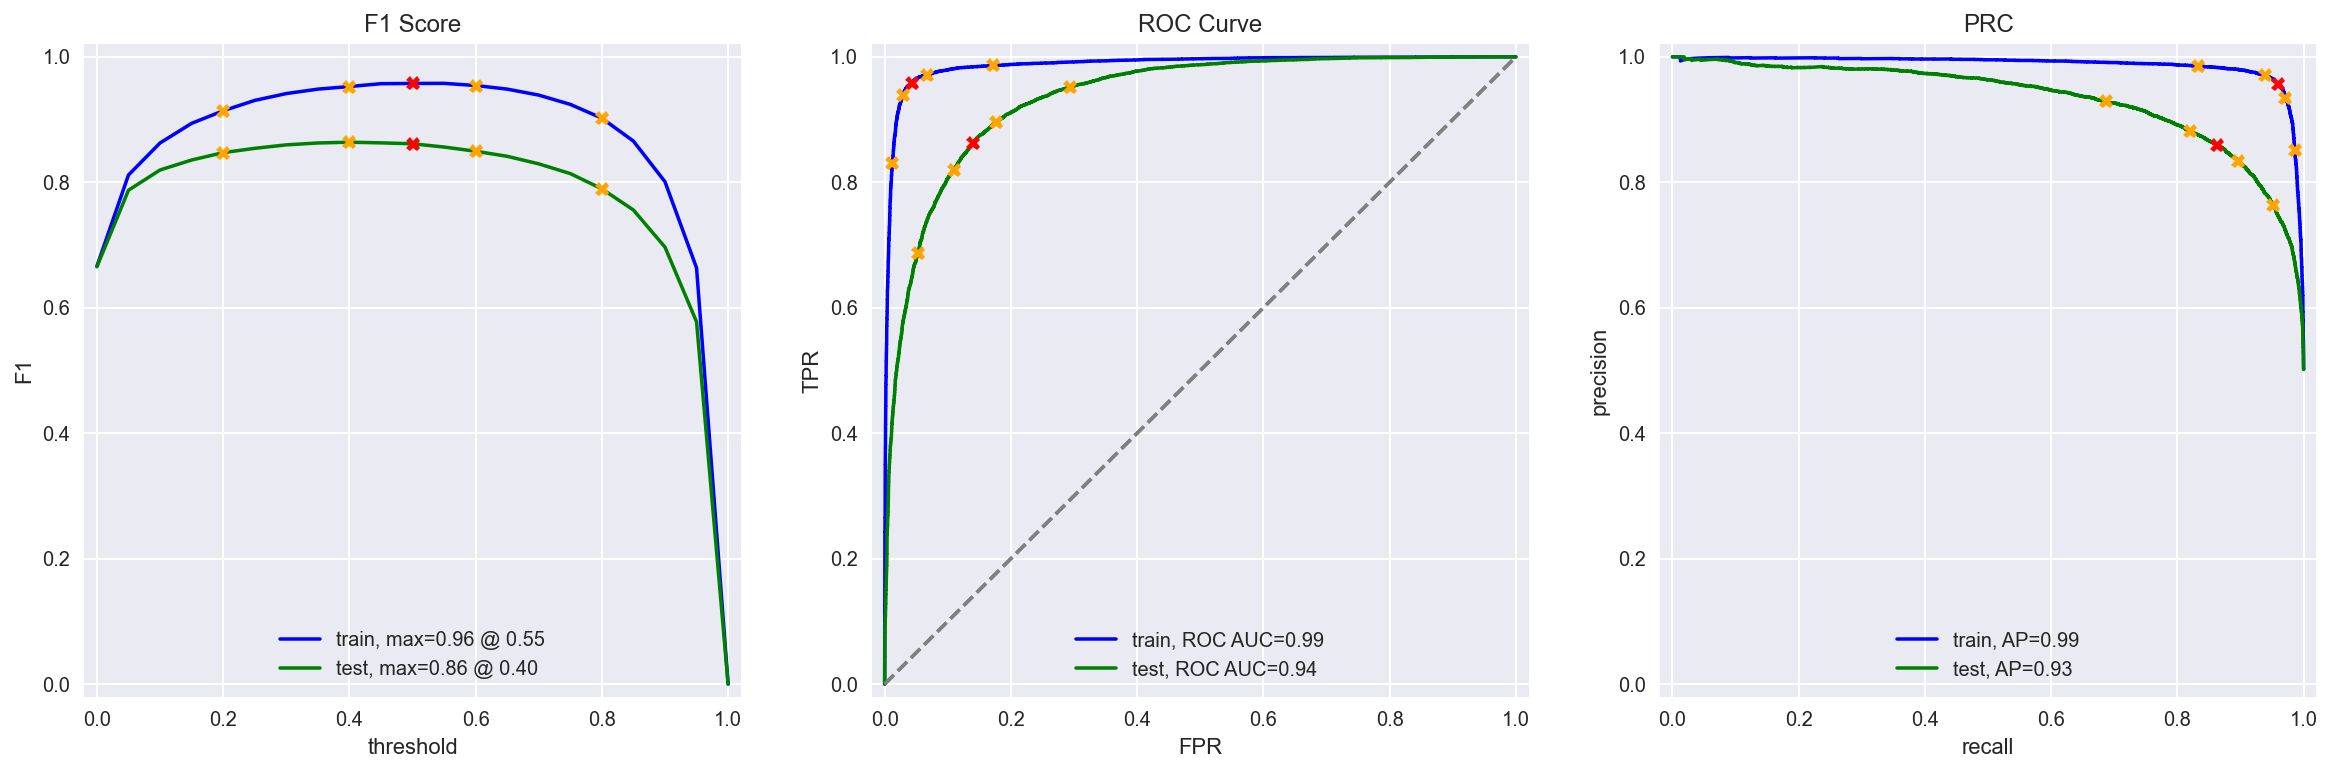

In [51]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

###  Model 5 - BERT

In [53]:
!pip install torch

In [ ]:
!pip install transformers

In [56]:
import torch
import transformers

In [57]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    max_length = 512

    for input_text in texts:
        ids = tokenizer.encode(
            input_text.lower(),
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
        )
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)])
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [60]:
train_features_5 = BERT_text_to_embeddings(df_reviews_train['review_norm'][:500])

Using the cpu device.


  0%|          | 0/5 [00:00<?, ?it/s]

In [61]:
print(df_reviews_train['review_norm'].shape)
print(train_features_5.shape)
print(train_target.shape)

(23796,)
(500, 768)
(23796,)


In [62]:
test_features_5 = BERT_text_to_embeddings(df_reviews_test['review_norm'][:500])

Using the cpu device.


  0%|          | 0/5 [00:00<?, ?it/s]

In [71]:
print(df_reviews_train['review_norm'].shape)
print(test_features_5.shape)
print(test_target.shape)

(23796,)
(500, 768)
(23533,)


In [73]:
np.savez_compressed('features_5.npz', train_features_5z=train_features_5, test_features_5z=test_features_5)

model_5 = LogisticRegression()

with np.load('features_5.npz') as data:
    train_features_5 = data['train_features_5z']
    test_features_5 = data['test_features_5z']

    model_5.fit(train_features_5, train_target[:500])

          train  test
Accuracy   0.99  0.81
F1         0.99  0.82
APS        1.00  0.91
ROC AUC    1.00  0.90


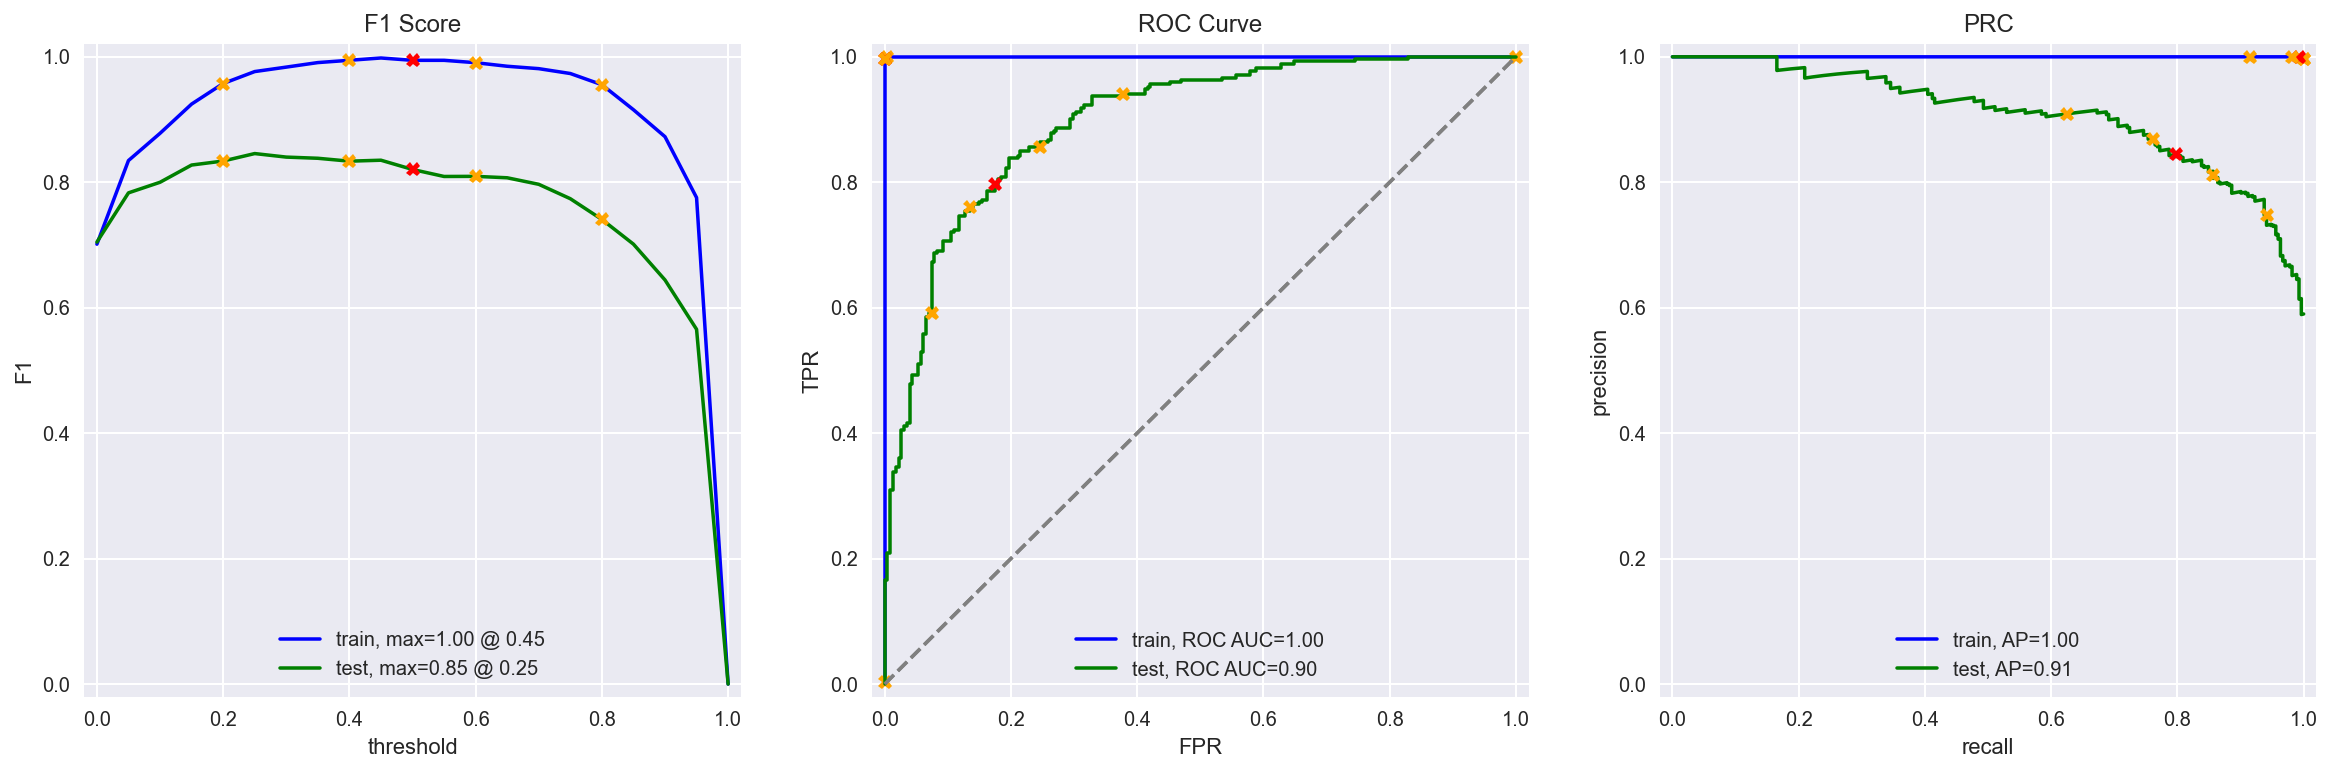

In [76]:
evaluate_model(model_5, train_features_5, train_target[:500], test_features_5, test_target[:500])

This model seems to be the most overfit, and surely suffers from the fact that I couldn't use the whole dataset due to compute resource constraits. 

## Test models on reviews I wrote

In [77]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


To further explore the abilities of these models, I preprocessed some new "reviews" that they could classify for sentiment. 

### Model 2

In [78]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [79]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.15:  well i was bored and felt asleep in the middle of the movie
0.47:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didn t expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [80]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.47:  i did not simply like it not my kind of movie
0.19:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.19:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didn t expect the reboot to be so good writers really cared about the source material
0.63:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.13:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


This provided some interesting results. The LightGBM model considered the reviews to be much more positive than the logistic regression models. Model 32 (the logistic regression model using NLTK) seems to pick up on negative sentiment the best, as it classifies the ones I consider the most negative as slightly more likely to be negative than the other model. 

### Model 5

In [82]:
texts = my_reviews['review_norm']

my_reviews_features_5 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_5.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.81:  i did not simply like it not my kind of movie
0.06:  well i was bored and felt asleep in the middle of the movie
0.90:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.52:  i didn t expect the reboot to be so good writers really cared about the source material
0.99:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.01:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.98:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusions

After evaluating the different models, and then using them to classify some new "reviews" that I provided, my opinion is that Model 2 is the best for this objective. While both Model 2 and Model 3 have the same f1 score, Model 2 is most sensitive to negative reviews, and the eventual purpose of this model is to automatically detect negative reviews. 